In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Input, Conv2D, Multiply, Add, Activation
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Dataset paths
pneumonia_dir = '/kaggle/input/vit-deeplearning/Split_Pneumonia/Split_Pneumonia'
covid19_dir = '/kaggle/input/vit-deeplearning/Split_COVID19/Split_COVID19'
tuberculosis_dir = '/kaggle/input/vit-deeplearning/Split_Tuberculosis/Split_Tuberculosis'

# Hyperparameters
batch_size = 32
img_size = (224, 224)
num_classes = 3  # Adjust if datasets have different classes
epochs = 10

Data Processing and Augmentation

In [3]:
def get_data_generators(dataset_path, batch_size=32, target_size=(224, 224)):
    """
    Create data generators for training, validation, and test datasets.
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Validation/Test data generator (no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # Training generator
    train_gen = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Validation generator
    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'val'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Test generator
    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Keep order for evaluation
    )

    return train_gen, val_gen, test_gen

# Create data generators for each dataset
train_gen_pneumonia, val_gen_pneumonia, test_gen_pneumonia = get_data_generators(pneumonia_dir, batch_size, img_size)
train_gen_covid19, val_gen_covid19, test_gen_covid19 = get_data_generators(covid19_dir, batch_size, img_size)
train_gen_tuberculosis, val_gen_tuberculosis, test_gen_tuberculosis = get_data_generators(tuberculosis_dir, batch_size, img_size)

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.
Found 2406 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Define the CBAM Module

In [4]:
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Dense,
    Reshape,
    Multiply,
    Conv2D,
    Activation,
    Concatenate,
    Add,
    Layer
)

# Custom Spatial Attention Layer
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = Conv2D(1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        return self.conv(concat)


def cbam_block(input_tensor, ratio=8):
    """
    Convolutional Block Attention Module (CBAM).
    Args:
        input_tensor: Input Keras Tensor.
        ratio: Reduction ratio for channel attention.
    Returns:
        Output tensor after applying CBAM.
    """
    # Channel Attention Module
    channel_dim = input_tensor.shape[-1]

    # Average pooling for channel attention
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Dense(channel_dim // ratio, activation='relu')(avg_pool)
    avg_pool = Dense(channel_dim, activation='sigmoid')(avg_pool)
    avg_pool = Reshape((1, 1, channel_dim))(avg_pool)

    # Max pooling for channel attention
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Dense(channel_dim // ratio, activation='relu')(max_pool)
    max_pool = Dense(channel_dim, activation='sigmoid')(max_pool)
    max_pool = Reshape((1, 1, channel_dim))(max_pool)

    # Combine channel attention
    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    # Spatial Attention Module (Uses Custom Layer)
    spatial_attention = SpatialAttention()(x)
    x = Multiply()([x, spatial_attention])

    return x


Define the Hybrid Model

In [5]:
def build_hybrid_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Builds a hybrid model using EfficientNetB0 and CBAM for attention.
    Args:
        input_shape: Shape of input images.
        num_classes: Number of output classes.
    Returns:
        A compiled Keras model.
    """
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

    # Apply CBAM block to the base model output
    cbam_output = cbam_block(base_model.output)

    # Add a classification head
    x = GlobalAveragePooling2D()(cbam_output)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    return model

Train the Model

In [6]:
def train_model(dataset_name, train_gen, val_gen, epochs, batch_size):
    """
    Trains a hybrid model on the given dataset.
    Args:
        dataset_name: Name of the dataset (used for saving checkpoints).
        train_gen: Training data generator.
        val_gen: Validation data generator.
        epochs: Number of training epochs.
        batch_size: Batch size for training.
    Returns:
        history: Training history.
        model: Trained Keras model.
    """
    print(f"Training on {dataset_name} dataset...")

    model = build_hybrid_model(num_classes=train_gen.num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        f"{dataset_name}_HybridModel.keras", save_best_only=True, monitor="val_accuracy", mode="max"
    )
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Training
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping],
    )
    return history, model


Evaluate and Visualize Results

In [7]:
def plot_training_results(history, dataset_name):
    """
    Plot accuracy and loss graphs for training and validation.
    """
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{dataset_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Run Training for All Datasets

Training on Pneumonia dataset...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 216s 978ms/step - accuracy: 0.8857 - loss: 0.2532 - val_accuracy: 0.7299 - val_loss: 2.6458
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 548ms/step - accuracy: 0.9578 - loss: 0.1267 - val_accuracy: 0.7299 - val_loss: 3.8169
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 544ms/step - accuracy: 0.9595 - loss: 0.1060 - val_accuracy: 0.7299 - val_loss: 4.0055
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 546ms/step - accuracy: 0.9625 - loss: 0.1028 - val_accuracy: 0.7299 - val_loss: 3.3592
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 545ms/step - accuracy: 0.9701 - loss: 0.0823 - val_accuracy: 0.8137 - val_loss: 0.8211
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 551ms/step - accuracy: 0.9717 - loss: 0.0725 - val_accuracy: 0.9333 - val_loss: 0.1500
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 545ms/step - accuracy: 0.9763 - loss: 0.0741 - val_accuracy: 0.9538 - val_loss: 0.1342
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 536ms/step - accuracy: 0.9791 - loss: 0.0702 - va

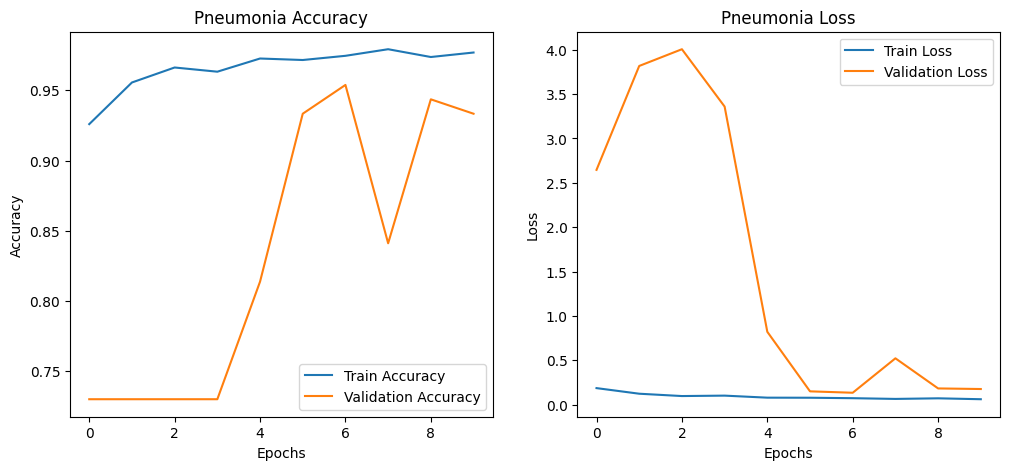

Training on COVID-19 dataset...
Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 309s 721ms/step - accuracy: 0.9071 - loss: 0.2244 - val_accuracy: 0.2949 - val_loss: 2.8637
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 134s 380ms/step - accuracy: 0.9647 - loss: 0.0958 - val_accuracy: 0.2616 - val_loss: 3.3569
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 134s 379ms/step - accuracy: 0.9736 - loss: 0.0838 - val_accuracy: 0.8551 - val_loss: 0.6159
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 133s 377ms/step - accuracy: 0.9786 - loss: 0.0613 - val_accuracy: 0.8761 - val_loss: 0.2991
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 134s 379ms/step - accuracy: 0.9804 - loss: 0.0540 - val_accuracy: 0.9507 - val_loss: 0.1293
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 132s 373ms/step - accuracy: 0.9836 - loss: 0.0487 - val_accuracy: 0.2804 - val_loss: 1.9464
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 133s 377ms/step - accuracy: 0.9827 - loss: 0.0458 - val_accuracy: 0.4536 - val_loss: 1.2600
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 134s

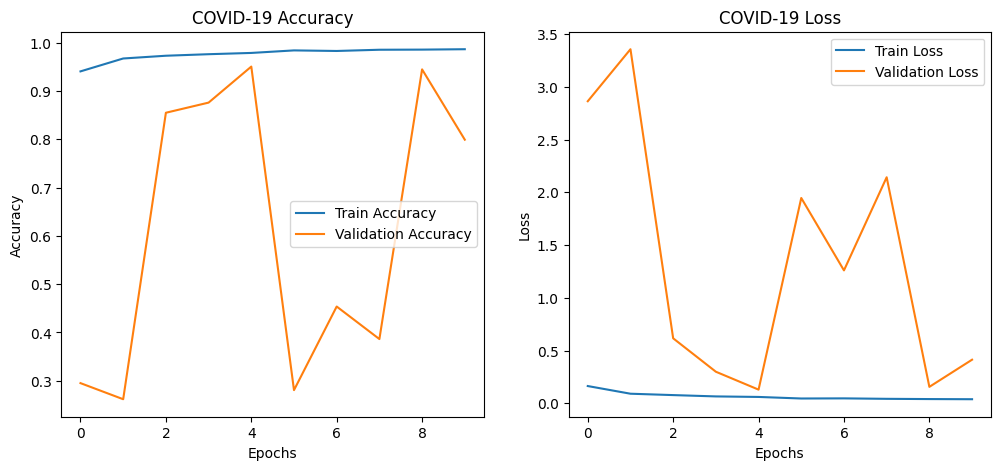

Training on Tuberculosis dataset...
Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9468 - loss: 0.1846 - val_accuracy: 0.8300 - val_loss: 1.3649
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 395ms/step - accuracy: 0.9907 - loss: 0.0295 - val_accuracy: 0.8300 - val_loss: 2.5805
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 335ms/step - accuracy: 0.9967 - loss: 0.0119 - val_accuracy: 0.8300 - val_loss: 0.8323
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - accuracy: 0.9955 - loss: 0.0204 - val_accuracy: 0.8300 - val_loss: 2.0980
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - accuracy: 0.9928 - loss: 0.0163 - val_accuracy: 0.8300 - val_loss: 1.6687
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 325ms/step - accuracy: 0.9938 - loss: 0.0188 - val_accuracy: 0.8300 - val_loss: 1.2632
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 336ms/step - accuracy: 0.9977 - loss: 0.0066 - val_accuracy: 0.8300 - val_loss: 0.8961
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step - accuracy

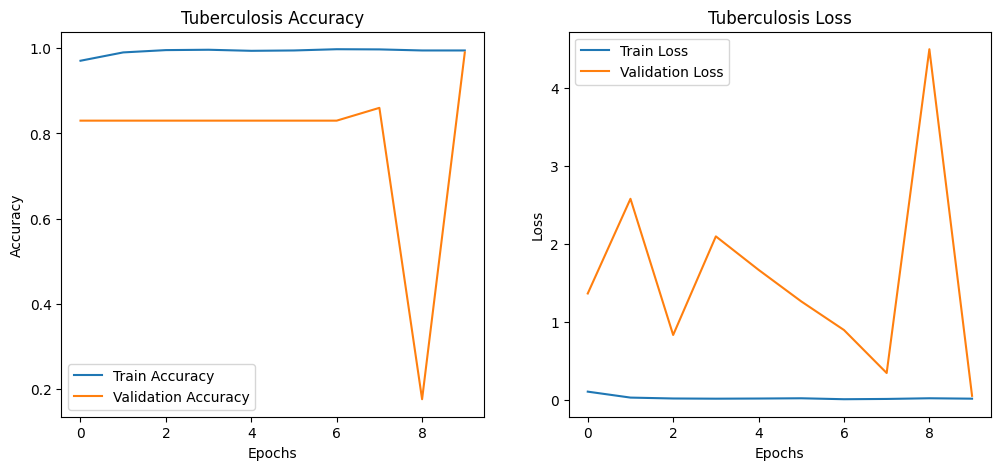

In [8]:
# Pneumonia Dataset
history_pneumonia, model_pneumonia = train_model(
    dataset_name="Pneumonia", train_gen=train_gen_pneumonia, val_gen=val_gen_pneumonia, epochs=epochs, batch_size=batch_size
)
plot_training_results(history_pneumonia, "Pneumonia")

# COVID-19 Dataset
history_covid19, model_covid19 = train_model(
    dataset_name="COVID-19", train_gen=train_gen_covid19, val_gen=val_gen_covid19, epochs=epochs, batch_size=batch_size
)
plot_training_results(history_covid19, "COVID-19")

# Tuberculosis Dataset
history_tuberculosis, model_tuberculosis = train_model(
    dataset_name="Tuberculosis", train_gen=train_gen_tuberculosis, val_gen=val_gen_tuberculosis, epochs=epochs, batch_size=batch_size
)
plot_training_results(history_tuberculosis, "Tuberculosis")

Test Accuracies

In [12]:
# Evaluate the Pneumonia model on the test dataset
pneumonia_test_loss, pneumonia_test_accuracy = model_pneumonia.evaluate(test_gen_pneumonia)
print(f"Pneumonia Test Accuracy: {pneumonia_test_accuracy * 100:.2f}%")

# Evaluate the COVID-19 model on the test dataset
covid_test_loss, covid_test_accuracy = model_covid19.evaluate(test_gen_covid19)
print(f"COVID-19 Test Accuracy: {covid_test_accuracy * 100:.2f}%")

# Evaluate the Tuberculosis model on the test dataset
tuberculosis_test_loss, tuberculosis_test_accuracy = model_tuberculosis.evaluate(test_gen_tuberculosis)
print(f"Tuberculosis Test Accuracy: {tuberculosis_test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.9488 - loss: 0.1582
Pneumonia Test Accuracy: 96.25%
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8868 - loss: 0.3059
COVID-19 Test Accuracy: 94.43%
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9486 - loss: 0.1119
Tuberculosis Test Accuracy: 97.02%
